In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
import time

import seaborn as sns

In [2]:
def decay5(data, window=5):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = cumsums*scale_arr[::-1]
    return out

def decay10(data, window=10):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    pw0 = alpha * alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = cumsums * scale_arr[::-1]
    return out

In [3]:
def featureEng(test_time = False):
    
    pkl_file = open('train_set.pkl', 'rb')
    train_set = pickle.load(pkl_file)
    pkl_file.close()
    
    if test_time == True:
        
        pkl_file = open('val_set.pkl', 'rb')
        val_set = pickle.load(pkl_file)
        pkl_file.close()
    
        pkl_file = open('test_set.pkl', 'rb')
        test_set = pickle.load(pkl_file)
        pkl_file.close()
    
        df = pd.concat([train_set, val_set, test_set])

    
    elif test_time == False:
    
        
        pkl_file = open('val_set.pkl', 'rb')
        val_set = pickle.load(pkl_file)
        pkl_file.close()
    
        df = pd.concat([train_set, val_set])
    
    else:
        
        print("unrecognized input for test_time...")
        
    df.sort_values('year', inplace = True)

    # ----------------------------------------------------------------------------------------------    
    # Getting xcoord and ycoord for plotting 
    pkl_file = open('full_df.pkl', 'rb')
    full_df = pickle.load(pkl_file)
    pkl_file.close()

    full_df.sort_values('year', inplace = True)
    full_df = full_df[full_df['year'] < 2015].copy()
    
    df['xcoord'] = full_df['xcoord_x']
    df['ycoord'] = full_df['ycoord_x']
    
    # ----------------------------------------------------------------------------------------------    
    df['past_fatalities'] = df.sort_values('year').groupby(['gid'])['best'].cumsum()
    df['past_magnitude'] = df.sort_values('year').groupby(['gid'])['log_best'].cumsum()
    df['past_events'] = df.sort_values('year').groupby(['gid'])['binary_best'].cumsum()

    df['past_fatalities_country'] = df.sort_values('year').groupby(['gwno'])['best'].cumsum()
    df['past_magnitude_country'] = df.sort_values('year').groupby(['gwno'])['log_best'].cumsum()
    df['past_events_country'] = df.sort_values('year').groupby(['gwno'])['binary_best'].cumsum()
    
    
    # ----------------------------------------------------------------------------------------------    
    features_to_normalize = ['gwarea', 'interp_pop_gpw_sum', 'past_fatalities_country', 'past_magnitude_country', 'past_events_country']

    for feature in features_to_normalize:

        new_name = 'norm_' + feature
        df[new_name] = (df[feature]- df[feature].min())/(df[feature].max()-df[feature].min())        
        

    # ----------------------------------------------------------------------------------------------
    df['past_fatalities_country_Narea'] = df['norm_past_fatalities_country'] / (df['norm_gwarea']+1)
    df['past_magnitude_country_Narea'] = df['norm_past_magnitude_country'] / (df['norm_gwarea']+1)
    df['past_events_country_Narea'] = df['norm_past_events_country'] / (df['norm_gwarea']+1)
    
    
    # ----------------------------------------------------------------------------------------------    
    df['norm_interp_pop_gpw_sum_country'] = df.sort_values('year').groupby(['gwno'])['norm_interp_pop_gpw_sum'].transform(np.sum)#


    df['past_fatalities_country_Npop'] = df['norm_past_fatalities_country'] / (df['norm_interp_pop_gpw_sum_country'])
    df['past_magnitude_country_Npop'] = df['norm_past_magnitude_country'] / (df['norm_interp_pop_gpw_sum_country'])
    df['past_events_country_Npop'] = df['norm_past_events_country'] / (df['norm_interp_pop_gpw_sum_country'])
    
    
    # ----------------------------------------------------------------------------------------------    
    df['best_decay5'] = df.sort_values('year').groupby(['gid'])['best'].apply(decay5)
    df['best_decay10'] = df.sort_values('year').groupby(['gid'])['best'].apply(decay10)
    
    df['log_best_decay5'] = df.sort_values('year').groupby(['gid'])['log_best'].apply(decay5)
    df['log_best_decay10'] = df.sort_values('year').groupby(['gid'])['log_best'].apply(decay10)

    # ----------------------------------------------------------------------------------------------
    df['cell_light_Pcap'] = (df['interp_nlights_mean'])/(df['norm_interp_pop_gpw_sum']+1)
    
    
    # ----------------------------------------------------------------------------------------------    
    df['interp_nlights_mean_country'] = df.sort_values('year').groupby(['gwno'])['interp_nlights_mean'].transform(np.sum)
    df['country_light_Pcap'] = (df['interp_nlights_mean_country'])/(df['norm_interp_pop_gpw_sum_country']+1)
    df['country_light_Area'] = (df['interp_nlights_mean_country'])/(df['norm_gwarea']+1)
    
    
    
    # ----------------------------------------------------------------------------------------------
    
    df['interp_nlights_mean_norm'] = (df['interp_nlights_mean'] - df['interp_nlights_mean'].min())/(df['interp_nlights_mean'].max()-df['interp_nlights_mean'].min())
    df['interp_nlights_mean_country_norm'] = (df['interp_nlights_mean_country'] - df['interp_nlights_mean_country'].min())/(df['interp_nlights_mean_country'].max()-df['interp_nlights_mean_country'].min())
    
    df['country_light_Pcap_norm'] = (df['country_light_Pcap'] - df['country_light_Pcap'].min())/(df['country_light_Pcap'].max()-df['country_light_Pcap'].min())
    df['country_light_Area_norm'] = (df['country_light_Area'] - df['country_light_Area'].min())/(df['country_light_Area'].max()-df['country_light_Area'].min())

    df['low_ratio_light'] = np.minimum(df['interp_nlights_mean_country_norm'] / df['interp_nlights_mean_norm'],1)  
    df['low_ratio_light_Pcap'] = np.minimum(df['country_light_Pcap_norm'] / df['interp_nlights_mean_norm'],1)  
    df['low_ratio_light_Area'] = np.minimum(df['country_light_Area_norm'] / df['interp_nlights_mean_norm'],1)
    
    # ----------------------------------------------------------------------------------------------
    
    df['interp_excluded_binary'] = (df['interp_excluded'] > 0) * 1
    
    # ----------------------------------------------------------------------------------------------

    
    last_year = df['year'].max()
    
    train_set = df[df['year'] < last_year]
    other_set = df[df['year'] == last_year] # val or test set

    return train_set, other_set

In [4]:
train_set, val_set = featureEng(test_time = False)
train_set_ttime, test_set = featureEng(test_time = True)

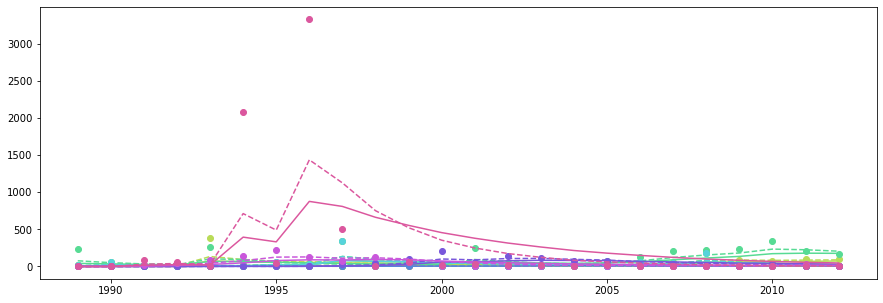

In [5]:
years = train_set['year'].unique()
some_gids = train_set[train_set['ratio_best']>0.6]['gid'].sample(10, replace = False)
colors = sns.color_palette("hls", some_gids.shape[0])

plt.figure(figsize = (15,5))

for i, gid in enumerate(some_gids):
    
    plt.plot(years, train_set[train_set['gid'] == gid]['best_decay5'], '--', color  = colors[i])
    plt.plot(years, train_set[train_set['gid'] == gid]['best_decay10'], '-', color  = colors[i])
    
    plt.plot(years, train_set[train_set['gid'] == gid]['best'], 'o', color  = colors[i])
    
plt.show()


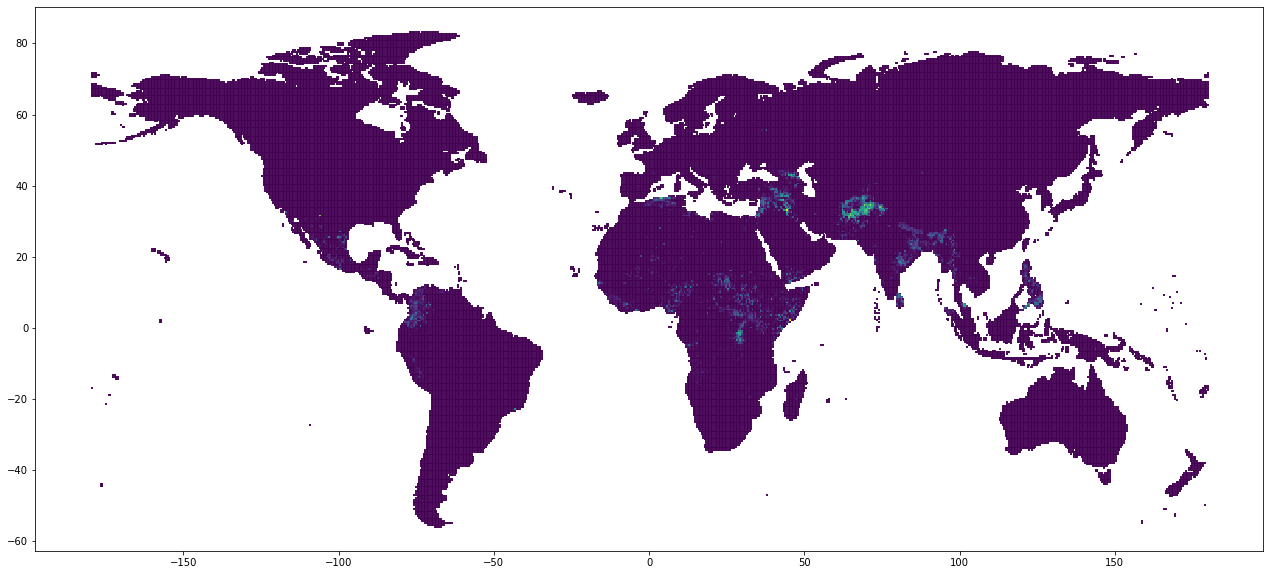

In [6]:
plt.figure(figsize = [22,10])
plt.scatter(train_set[train_set['year'] == 2012]['xcoord'], train_set[train_set['year'] == 2012]['ycoord'], c = train_set[train_set['year'] == 2012]['log_best_decay10'], s=1, marker='s')
plt.show()

In [7]:
ys = ['binary_best_t1','binary_best_t2','binary_best_t3','binary_best_t4','binary_best_t5']
XsDrops = ['geometry', 'binary_best_t1', 'binary_best_t2', 'binary_best_t3', 'binary_best_t4', 'binary_best_t5']

y_train = pd.DataFrame(train_set[ys])
X_train = pd.DataFrame(train_set.drop(XsDrops, axis =1))

y_val = pd.DataFrame(val_set[ys])
X_val = pd.DataFrame(val_set.drop(XsDrops, axis =1))

y_train_ttime = pd.DataFrame(train_set_ttime[ys])
X_train_ttime = pd.DataFrame(train_set_ttime.drop(XsDrops, axis =1))

y_test = pd.DataFrame(test_set[ys])
X_test = pd.DataFrame(test_set.drop(XsDrops, axis =1))

In [8]:
print(y_train.info())
print('\n')

print(X_train.info())
print('\n')

print(y_val.info())
print('\n')

print(X_val.info())
print('\n')

print(y_train_ttime.info())
print('\n')

print(X_train_ttime.info())
print('\n')

print(y_test.info())
print('\n')

print(X_test.info())
print('\n')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1555632 entries, 0 to 1512421
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   binary_best_t1  1555632 non-null  float64
 1   binary_best_t2  1555632 non-null  float64
 2   binary_best_t3  1555632 non-null  float64
 3   binary_best_t4  1555632 non-null  float64
 4   binary_best_t5  1555632 non-null  float64
dtypes: float64(5)
memory usage: 71.2 MB
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1555632 entries, 0 to 1512421
Data columns (total 56 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   gid                               1555632 non-null  int64  
 1   gwno                              1555632 non-null  float64
 2   gwarea                            1555632 non-null  float64
 3   year                              1555632 non-null  int64  
 4   int

In [9]:
file_name = "y_train_week12.pkl"
output = open(file_name, 'wb')
pickle.dump(y_train, output)
output.close()

file_name = "X_train_week12.pkl"
output = open(file_name, 'wb')
pickle.dump(X_train, output)
output.close()

file_name = "y_val_week12.pkl"
output = open(file_name, 'wb')
pickle.dump(y_val, output)
output.close()

file_name = "X_val_week12.pkl"
output = open(file_name, 'wb')
pickle.dump(X_val, output)
output.close()

file_name = "y_train_ttime_week12.pkl"
output = open(file_name, 'wb')
pickle.dump(y_train_ttime, output)
output.close()

file_name = "X_train_ttime_week12.pkl"
output = open(file_name, 'wb')
pickle.dump(X_train_ttime, output)
output.close()

file_name = "y_test_week12.pkl"
output = open(file_name, 'wb')
pickle.dump(y_test, output)
output.close()

file_name = "X_test_week12.pkl"
output = open(file_name, 'wb')
pickle.dump(X_test, output)
output.close()
